In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow.keras as k

import csv
import json

In [21]:
# helper functions
output_format = ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'clubs', 'spades', 'diamonds', 'hearts', 'joker']
def parse_output(output: np.array) -> str:
    """
    Parse the output from a list of numbers into a string like 'joker' or 'ace of hearts' or 'eight of spades'
    :param output: the output from the DL model as a list of 18 numbers between 0 and 1
    :return: string name of the card
    """
    test = [not (0 <= num <= 1) for num in output]
    if output.shape != np.array(output_format).shape:
        raise ValueError('output is not of the correct shape')
    elif any(test):
        raise ValueError(f'Output is not correctly formatted. All values in output must be between 0 and 1.\n'
                         f'given output: {output}\n'
                         f'\thas incorrect values at indices {[i if test[i] else _ for i in range(len(test))]}')
    elif max(output) == output[-1]:
        return 'joker'
    outputs = list(output)
    rank_index = outputs[:13].index(max(output[:13])) # index of most probable rank
    suit_index = outputs[13:17].index(max(output[13:17])) + 13 # index of most probable suit
    return f"{output_format[rank_index]} of {output_format[suit_index]}"

def build_cnn_model(c_layers=1, d_layers=2, dense_neurons=64, filters=32, max_pooling=2, stride=3, filter_size=5, dropout=0.3)-> tf.keras.Model:
    """
    Build a convolutional sequential deep learning model.
    
    :param c_layers: Number of convolutions. Default 1.
    :param d_layers: Number of fully connected layers applied after convolutions. Default 2.
    :param dense_neurons: Number of neurons in each fully connected layers. Default 64.
    :param filters: Number of filters for first convolution. Each convolution will have twice the filters of the previous layer. Default 32.
    :param max_pooling: How large should max pooling be, setting 0 or 1 will disable max pooling. Anything larger will set the max pool at a square of that size. Default 32.
    :param stride: Stride for each convolution layer. Default 3.
    :param filter_size: The size of each filter in the convolution. Default 5.
    :param dropout: How strongly to apply dropout layers, value should be between 0 and 1, with 0 disabling dropout. Default 0.3.
    :return: built but uncompiled CNN model based on parameter specifications.
    """
    model = k.Sequential()
    
    model.add(k.Input(shape=(224, 224, 3)))
    
    for i in range(c_layers):
        model.add(k.layers.Conv2D(filters * (2 ** i), (filter_size, filter_size), padding='same', strides=(stride, stride), activation=k.layers.LeakyReLU(negative_slope=0.01)))
        model.add(k.layers.BatchNormalization())
        if max_pooling > 1:
            model.add(k.layers.MaxPooling2D((max_pooling, max_pooling)))

    
    model.add(k.layers.Flatten())
    for i in range(d_layers):
        model.add(k.layers.Dense(dense_neurons, activation=k.layers.LeakyReLU(negative_slope=0.01)))
    
    if dropout > 0:
        model.add(k.layers.Dropout(dropout))
        
    model.add(k.layers.Dense(len(output_format), activation='softmax'))
    
    return model

def test_model(model: )

In [40]:
# import and assemble data
train_inputs = []
train_outputs = []
validation_inputs = []
validation_outputs = []
test_inputs = []
test_outputs = []


print(output_format)
print("loading data...")
with open('data/cards.csv', 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')

    flag = True
    for row in csv_reader:
        # print(row)
        if flag:
            headers = row
            flag = False
        else:
            # determine input
            img = np.asarray(Image.open('data/'+row[1]))
            
            # determine output
            name = row[2]
            print(name, end=" encoded as ")
            output = [1 if title in name else 0 for title in output_format]
                
            if sum(output) == 2 and name != 'joker': # suit and number activated
                output = np.array(output)
                print(output)
            elif sum(output) == 1 and name == 'joker': # just joker activated
                output = np.array(output)
                print(output)
            else:
                print(f"Something went wrong with {'data/'+row[1]}.")
                exit(1)
                
            # assembling data
            if 'train' == row[4]:
                train_inputs.append(img)
                train_outputs.append(output)
            elif 'test' == row[4]:
                test_inputs.append(img)
                test_outputs.append(output)
            elif 'valid' == row[4]:
                validation_inputs.append(img)
                validation_outputs.append(output)
            else:
                print(f"Something went wrong with {'data/'+row[1]} and category {row[4]}")
                exit(1)
                
train_inputs = np.array(train_inputs) / 255 # Normalize pixel values between 0 and 1
train_outputs = np.array(train_outputs)
validation_inputs = np.array(validation_inputs) / 255 # Normalize pixel values between 0 and 1.
validation_outputs = np.array(validation_outputs)
test_inputs = np.array(test_inputs) / 255 # Normalize pixel values between 0 and 1.
test_outputs = np.array(test_outputs)

print("Data importing complete")


['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'clubs', 'spades', 'diamonds', 'hearts', 'joker']
loading data...
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ace of clubs encoded as

nine of spades
	ace - 0
	two - 0
	three - 0
	four - 0
	five - 0
	six - 0
	seven - 0
	eight - 0
	nine - 1
	ten - 0
	jack - 0
	queen - 0
	king - 0
	clubs - 0
	spades - 1
	diamonds - 0
	hearts - 0
	joker - 0
ace of hearts
	ace - 1
	two - 0
	three - 0
	four - 0
	five - 0
	six - 0
	seven - 0
	eight - 0
	nine - 0
	ten - 0
	jack - 0
	queen - 0
	king - 0
	clubs - 0
	spades - 0
	diamonds - 0
	hearts - 1
	joker - 0
four of hearts
	ace - 0
	two - 0
	three - 0
	four - 1
	five - 0
	six - 0
	seven - 0
	eight - 0
	nine - 0
	ten - 0
	jack - 0
	queen - 0
	king - 0
	clubs - 0
	spades - 0
	diamonds - 0
	hearts - 1
	joker - 0
jack of hearts
	ace - 0
	two - 0
	three - 0
	four - 0
	five - 0
	six - 0
	seven - 0
	eight - 0
	nine - 0
	ten - 0
	jack - 1
	queen - 0
	king - 0
	clubs - 0
	spades - 0
	diamonds - 0
	hearts - 1
	joker - 0
four of clubs
	ace - 0
	two - 0
	three - 0
	four - 1
	five - 0
	six - 0
	seven - 0
	eight - 0
	nine - 0
	ten - 0
	jack - 0
	queen - 0
	king - 0
	clubs - 1
	spades - 0
	diamonds - 0


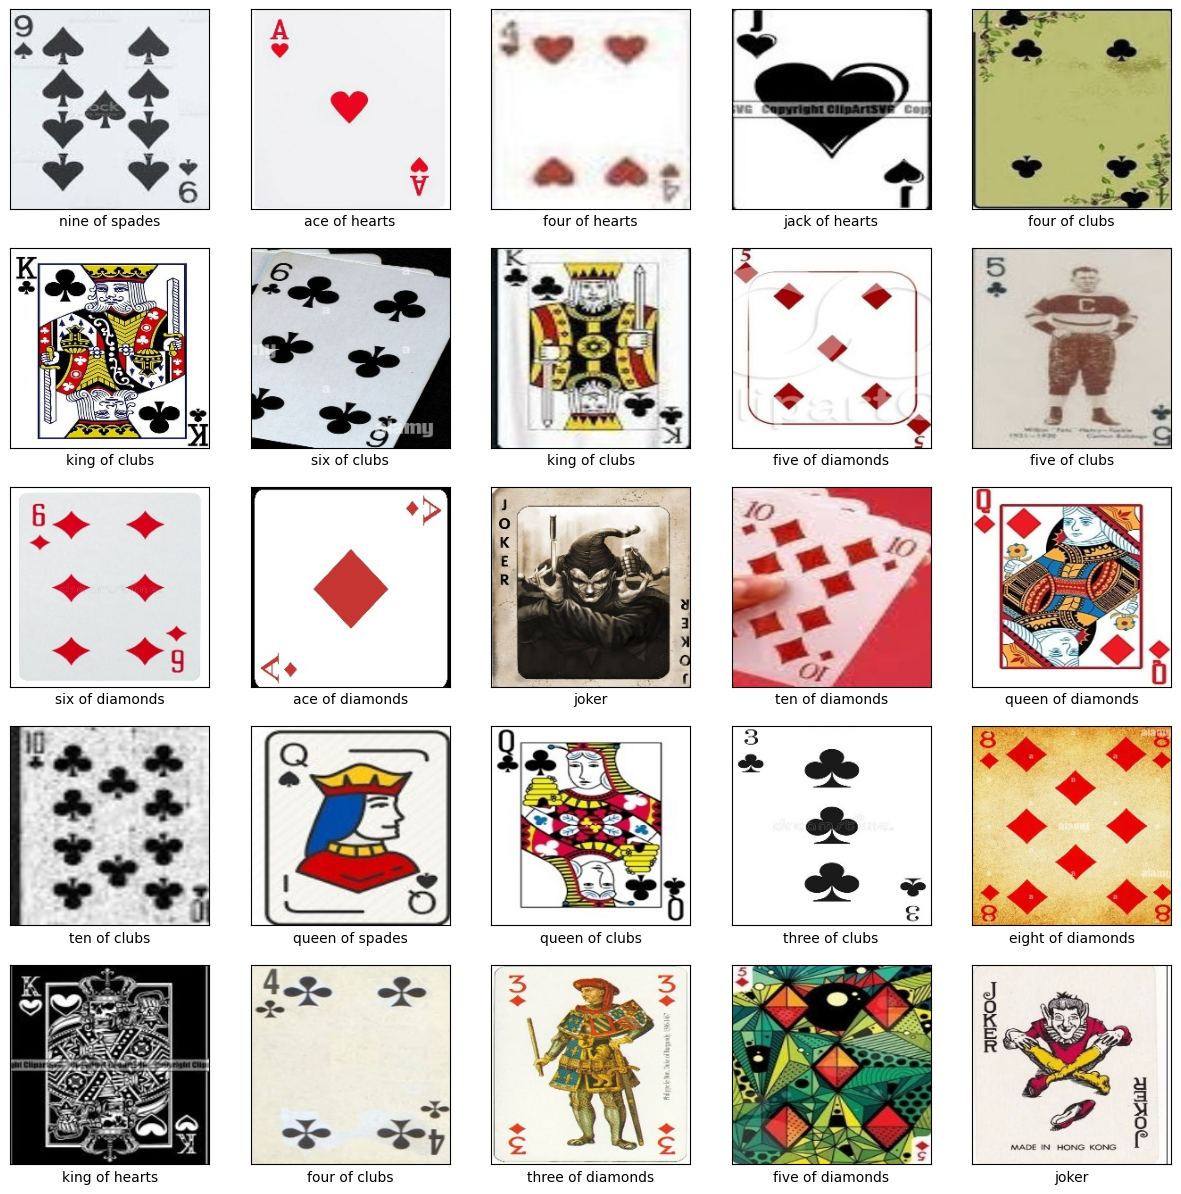

In [51]:
# check random samples
import random
from math import sqrt, ceil

num_samples = 25


samples = []
index = random.randint(0, len(train_inputs)-1)
while len(samples) < 25: # grab 25 different samples
    if index not in samples:
        samples.append(index)
    index = random.randint(0, len(train_inputs)-1)

plt.figure(figsize=[15,15]) # plot the samples
counter = 1
dim = ceil(sqrt(num_samples))

for index in samples:
    # print(train_inputs[index])
    plt.subplot(dim, dim, counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_inputs[index])
    plt.xlabel(parse_output(train_outputs[index]))
    counter += 1
    print(parse_output(train_outputs[index]))
    for i in range(len(output_format)):
        print(f"\t{output_format[i]} - {train_outputs[index][i]}")
    
plt.show()
        

In [56]:
model = build_cnn_model(c_layers=2, d_layers=1, dense_neurons=32, filters=4, filter_size=3, )

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 75, 75, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 75, 75, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 37, 37, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 13, 13, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 13, 13, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,298 (40.23 KB)

 Trainable params: 10,274 (40.13 KB)

 Non-trainable params: 24 (96.00 B)

In [57]:
k.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [47]:
# Learning rate scheduler
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=10.0,
    decay_steps=1000,
    decay_rate=0.999
)

# Create an optimizer with the learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compile model
model.compile(optimizer=opt, loss=k.losses.categorical_crossentropy, metrics=['accuracy'])


In [39]:
# Train the model
num_epochs = 25
history = model.fit(
    train_inputs, train_outputs,
    epochs=num_epochs,
    batch_size=32,
    validation_data=(validation_inputs, validation_outputs),
    verbose=1
)
    

Epoch 1/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.0308 - loss: 4746386604032.0000 - val_accuracy: 0.0000e+00 - val_loss: 17937473732608.0000
Epoch 2/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.0341 - loss: 14464101384192.0000 - val_accuracy: 0.0755 - val_loss: 17107993493504.0000
Epoch 3/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.0349 - loss: 25318253395968.0000 - val_accuracy: 0.0000e+00 - val_loss: 37831141490688.0000
Epoch 4/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.0299 - loss: 45167994208256.0000 - val_accuracy: 0.0000e+00 - val_loss: 60075041357824.0000
Epoch 5/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0266 - loss: 68265162309632.0000 - val_accuracy: 0.0000e+00 - val_loss: 78634626842624.0000
Epoch 6/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0294 - loss: 88585168486400.0000 - val_accuracy: 0.0755 - val_loss: 127501909098496.0000
Epoch 7/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step -

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# test classification
y_pred = model.predict(test_inputs)
